 Using pretrained models for image captioning
===========================================================




Instantiate a pre-trained architecture, Get predictions for arbitrary input, Fine-tune the pre-trained models for data set.

We use nlpconnect/vit-gpt2-image-captioning&rdquo; pre-trained image captioner, which uses an instance of VIT for image encoding and GTP-2 for decoding via causal language modeling.



## Packages



In [1]:
pip install torch

In [2]:
pip install --upgrade torchtext

^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import packages
from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel
from torch.utils.data import Dataset
from torchtext.data import get_tokenizer
import requests
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from datasets import load_dataset
import torch.nn as nn
from transformers import ViTFeatureExtractor
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

c:\Users\raush\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


Import the general &rsquo;VisionEncoderDecoderModel&rsquo; module from the &rsquo;transformers&rsquo; package, as well as the tokenizer for the decoder and the image processor for the encoder component (here GPT2 and VIT).
The &rsquo;requests&rsquo; package allows us to open pictures from URLs .



## Loading the pretrained model 

In [7]:
model_raw = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
#"nlpconnect/vit-gpt2-image-captioning" a combined model that uses the Vision Transformer (ViT) for image processing and the GPT-2 architecture for generating captions


In order to be able to feed this image+language model with images and language, we need an image processor and a tokenizer that fits the model components used for encoding and decoding.



In [8]:
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# ViTImageProcessor is used to preprocess images before they are fed into the model.
tokenizer       = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# GPT2TokenizerFast is used to tokenize and encode text data.

## Generating captions



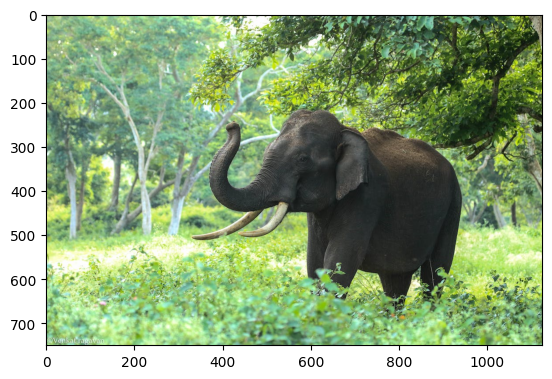

a large gray elephant is standing in a field 


In [9]:
# Define a function to show an image and generate a caption using a given URL.
def image_caption_generate(url, greedy = True, model = model_raw):
    image = Image.open(requests.get(url, stream =True).raw) # Open the image from the provided URL using PIL
    
    pixel_values   = image_processor(image, return_tensors ="pt").pixel_values
    # Preprocess the image using the ViTImageProcessor and retrieve pixel values.
    plt.imshow(np.asarray(image))
    plt.show()

    if greedy: # The model will select the token with the highest probability at each step.
        generated_ids  = model.generate(pixel_values, max_new_tokens = 30)
    else:
        generated_ids  = model.generate(
            pixel_values,
            do_sample=True, # random sampling will be used for token selection.
            max_new_tokens = 30,  # generates captions with a maximum of 30 tokens
            top_k=5) #top 5 probable tokens will be considered during sampling.

    # Decode the generated caption tokens using the tokenizer.        
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)

url = "https://images.pexels.com/photos/982021/pexels-photo-982021.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
image_caption_generate(url, greedy = False) # Call the function to display the image and generate a caption using a non-greedy approach.

## Fine-tuning on the data set



### The &rsquo;Dataset&rsquo; object



In [12]:
# Define the custom dataset class.
class Custom_Dataset(Dataset):
    def __init__(self, image_folder, caption_file, transform=None):
        self.image_folder = image_folder
        self.caption_file = caption_file
        self.data = self._read_data() # Read data from caption file.
        self.transform = transform

    def _read_data(self):
        data = []
        with open(self.caption_file, 'r') as f:
            lines = f.readlines()[1:]  # Skip the header line
            for line in lines:
                image_name, caption = line.strip().split(',', 1) # Split the line at the first comma.
                image_path = os.path.join(self.image_folder, image_name)  # Create the complete image path
                data.append((image_path, caption))
        return data # Return the list of image-caption pairs

    def __len__(self):
        return len(self.data) # Return the total number of data samples in the dataset.

    def __getitem__(self, idx):
        image_path, caption = self.data[idx]  # Get the image path and caption corresponding to the given index.
        image = Image.open(image_path).convert('RGB')   # Open the image using PIL and convert it to RGB format.

        if self.transform:
            image = self.transform(image)   # Apply transformations to the image.

        return image, caption

image_folder = 'Images'
caption_file = 'captions/captions.txt'
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 64x64 pixels.
    transforms.ToTensor(),        # Convert the image to a PyTorch tensor.
])
# Create an instance of the custom dataset.
dataset = Custom_Dataset(image_folder, caption_file, transform=transform)

### Creating a &rsquo;DataLoader&rsquo;



In [13]:
# Create a DataLoader from the dataset
batch_size = 1
Custom_Dataset_data_loader = torch.utils.data.DataLoader(
    dataset=dataset,  # Custom_Dataset dataset  
    batch_size=batch_size,
    shuffle=True,   # Shuffle the data at the beginning of each epoch
)

### Fine-tuning training



In [15]:

# Load a pretrained VisionEncoderDecoderModel for training.
model_trained = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Initialize an Adam optimizer for parameter updates.
optimizer = torch.optim.Adam(model_trained.parameters(), lr=1e-6)
# Training loop
for i in tqdm(range(10)):
    x = next(iter(Custom_Dataset_data_loader))   # Fetch the next batch of data from the data loader.

    # retrieve and preprocess image
    image = x[0][0]

    # Convert the tensor image to a NumPy array and then to a PIL image
    image = transforms.ToPILImage()(image)

    # Process the image using the image_processor to obtain pixel values as a PyTorch tensor.
    pixel_values = image_processor(images=image, return_tensors="pt").pixel_values

    # retrieve and preprocess labels
    labels = x[1][0]

    # Tokenize the caption text using the tokenizer and convert to PyTorch tensor.
    labels = tokenizer(labels, return_tensors="pt").input_ids

    # compute loss
    model_output = model_trained(pixel_values=pixel_values, labels=labels)
    loss = model_output.loss

    # parameter update
    loss.backward()   # computes gradients of the loss with respect to the model's parameters. Backpropagation is used to calculate these gradients by propagating the loss backward through the model's layers
    optimizer.step()  #  optimizer adjusts the parameters in a way that aims to reduce the loss in subsequent iterations
    optimizer.zero_grad()  # Reset gradients for the next iteration , After the parameter update, the gradients computed during the backward pass are accumulated in the grad attributes of the model's parameters To avoid gradients from accumulating across iterations, we zero them out at the beginning of each iteration

100%|██████████| 10/10 [01:38<00:00,  9.87s/it]


In [16]:
output_dir = "fine_tuned_model"
os.makedirs(output_dir, exist_ok=True)
model_trained.save_pretrained(output_dir) #saves the fine-tuned model to directory
tokenizer.save_pretrained(output_dir) #saves the tokenizer to the same output directory.

('fine_tuned_model\\tokenizer_config.json',
 'fine_tuned_model\\special_tokens_map.json',
 'fine_tuned_model\\vocab.json',
 'fine_tuned_model\\merges.txt',
 'fine_tuned_model\\added_tokens.json',
 'fine_tuned_model\\tokenizer.json')

In [17]:
import gradio as gr

def my_function(image):
    # Preprocess the image
    pixel_values   = image_processor(image, return_tensors ="pt").pixel_values
    plt.imshow(np.asarray(image))   # Display the image using matplotlib
    plt.show()
    # Generate a caption using the fine-tuned model
    generated_ids  = model_trained.generate(
    pixel_values,
    do_sample=True,
    max_new_tokens = 30,
    top_k=5)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return generated_text

iface = gr.Interface(
    fn=my_function,
    inputs="image",       # Input type: 'image' (user uploads an image)
    outputs="text",      # Output type: 'text' (generated caption)
    title="Image Caption",  
    description="Description of my interface",  
    live=True,           
    theme="default"     ) 

iface.launch()  # Launch the interface


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
